## Importing libraries

---

In [2]:
# Importing libraries

# Data treatment
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path
import sys
sys.path.append('../')

# Config
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from src.support import time_evolution, box_plot

## Load data

---

In [3]:
path = "../data/output/data_clean.csv"

df = pd.read_csv(path)

# Conveting dates to datetime
df['Posting Date'] = pd.to_datetime(df['Posting Date'])

## Data visualization

---

### Revenues comparison by category

---

If we want to compare 'Updated Budgeted Amount', 'Posted Amount', and 'Actual Amount', first we can build a dataframe with those quantities grouped by Economic Category and filtered by not-null values in any of those columns. 

This filter is important since it makes no sense comparing the sum of values in columns with different number of entries.

In [4]:
df_mounts = df[df['Updated Budgeted Amount'].notna() & df['Actual Amount'].notna() & df['Posted Amount'].notna()].groupby('Economic Category')[['Updated Budgeted Amount', 'Posted Amount', 'Actual Amount']].sum()

df_mounts

,Updated Budgeted Amount,Posted Amount,Actual Amount
Economic Category,,,
Current Revenues,2.052025e+09,134974266.4,1.954748e+09


Since 'Updated Budgeted Amount' and 'Posted Amount' have a lot of missing values, most of categories don't even have a single entry with all values available. For this reason we will exclue 'Posted Amount' in the analysis and compare only 'Updated Budgeted Amount' with 'Actual Amount'

In [5]:
df_mounts = df[df['Updated Budgeted Amount'].notna() & df['Actual Amount'].notna()].groupby('Economic Category')[['Updated Budgeted Amount', 'Actual Amount']].sum()

df_mounts

,Updated Budgeted Amount,Actual Amount
Economic Category,,
Capital Revenues,9.889837e+12,2.967413e+12
Current Revenues,6.896496e+12,3.264983e+12
Intra-Budgetary Current Revenues,1.250409e+11,9.377293e+10
No Information,9.754965e+11,5.198354e+10


In [6]:
df.shape[0]

1026214

In [7]:
df[df['Updated Budgeted Amount'].notna() & df['Actual Amount'].notna()].shape[0]

8837

Despite of having only 8837 entries out of 1026214 and `Intra-Budgetary Capital Revenues` missing, we still can get some valuable insights.

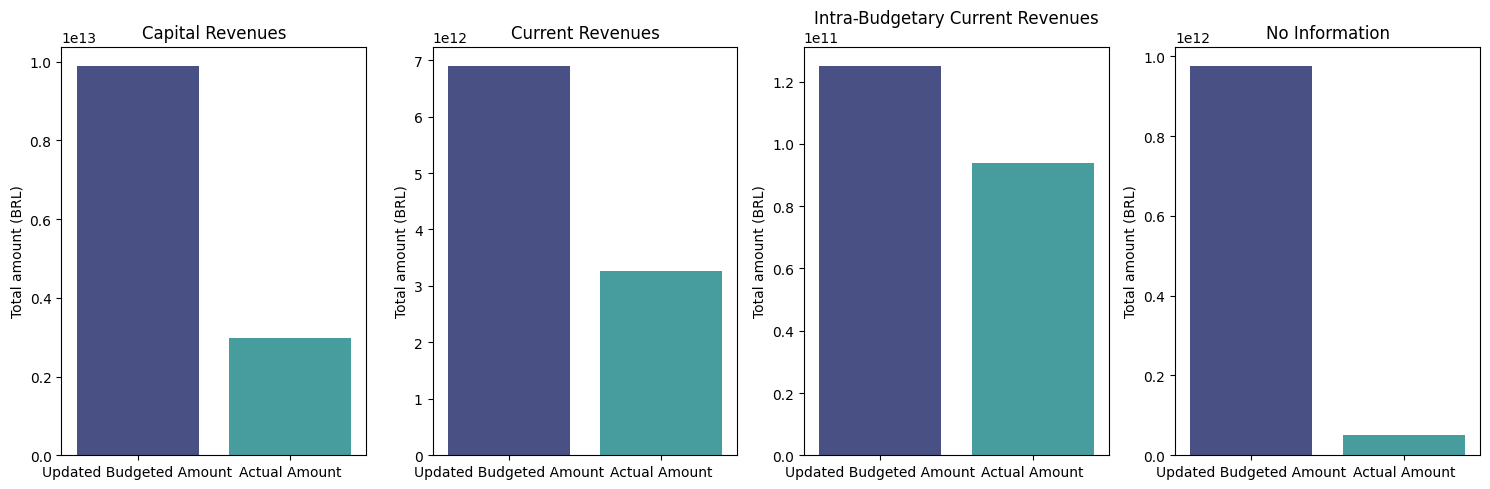

In [8]:
fig, axes = plt.subplots(1, len(df_mounts), figsize=(15, 5))

# Storing categories in a list
categories = df_mounts.index

for i, category in enumerate(categories):

    sns.barplot(x=df_mounts.loc[category].index, 
                y=df_mounts.loc[category].values,  
                ax=axes[i], 
                palette='mako')
    
    # Title for every subplot
    
    axes[i].set_title(category)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Total amount (BRL)')

plt.tight_layout()
plt.show()


Conclusions:

- Across all categories shown in the chart, there is a large discrepancy between the `Updated Budgeted Amount` and the `Actual Amount`. `Capital Revenues` and `Current Revenues` categories show the highest difference, where the actual revenues fall significantly short of the budgeted amount.

- The fact that we only have 8837 entries out of a possible > 1M (less than 1% of the total dataset) suggests that the data might not be fully representative. This could point to issues such as incomplete data collection or processing, making it difficult to draw definitive conclusions from this smaller dataset alone.

- `Capital Revenues` and `Current Revenues` are the dominant categories in terms of total amounts (both budgeted and actual). However, given the stark difference between budgeted and actual figures, it suggests either inefficiencies in revenue collection or overly optimistic budgeting.

---

Since we have revenues accumulated throughout the year are recognized in one batch, let's check what happens considering the whole data.

In [9]:
df_mounts = df.groupby('Economic Category')[['Updated Budgeted Amount', 'Actual Amount']].sum()

df_mounts

,Updated Budgeted Amount,Actual Amount
Economic Category,,
Capital Revenues,1.349986e+13,1.200415e+13
Current Revenues,1.314475e+13,1.202508e+13
Intra-Budgetary Capital Revenues,1.080841e+10,2.141127e+10
Intra-Budgetary Current Revenues,2.694278e+11,2.805787e+11
No Information,1.016380e+12,3.271665e+11


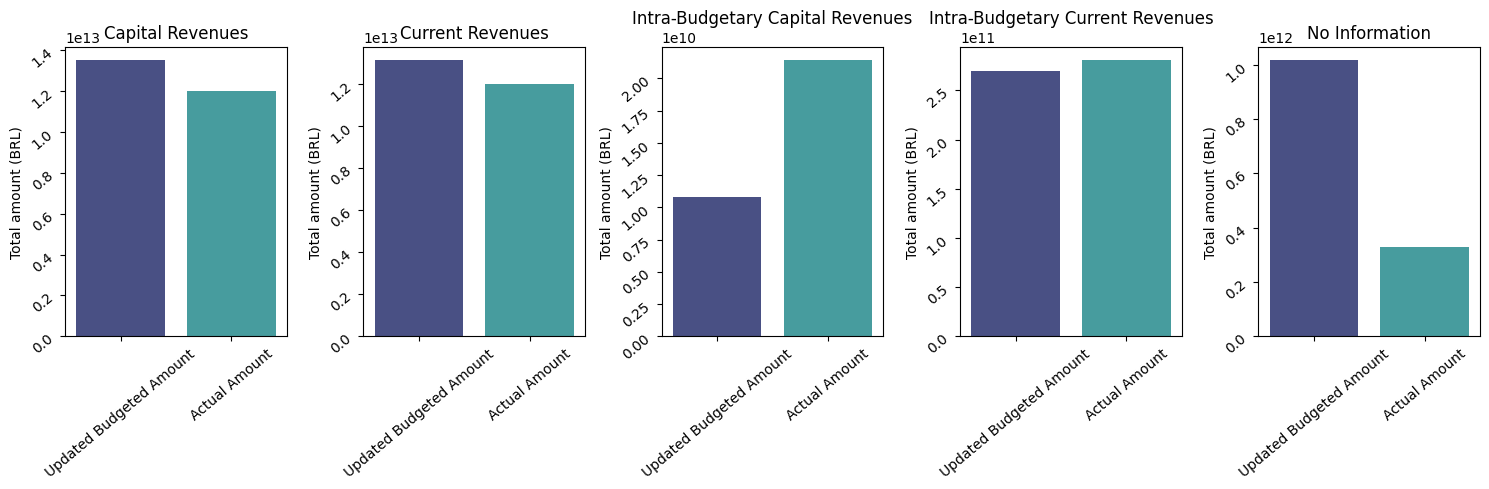

In [10]:
fig, axes = plt.subplots(1, len(df_mounts), figsize=(15, 5))

# Storing categories in a list
categories = df_mounts.index

for i, category in enumerate(categories):

    sns.barplot(x=df_mounts.loc[category].index, 
                y=df_mounts.loc[category].values,  
                ax=axes[i], 
                palette='mako')
    
    # Title for every subplot
    
    axes[i].set_title(category)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Total amount (BRL)')
    axes[i].tick_params(rotation = 40)

plt.tight_layout()
plt.show()

We can observe some key insights considering the complete data.

- `Capital Revenues` and `Current Revenues` remain the dominant categories in terms of total budgeted and actual amounts. However, the discrepancy between the `Updated Budgeted Amount` and `Actual Amount` has been reduced compared to the previous chart. In both categories, `Actual Revenues` are somewhat close to `Budgeted Revenues`, although the actual amounts are still slightly lower than projected.

- The `Intra-Budgetary Capital Revenues` now appears in the chart, revealing an interesting pattern: the actual revenues for 'Intra-Budgetary Capital' exceed the budgeted amount. This indicates potential underestimation during the budget planning process or overperformance in terms of capital collections. On the other hand, `Intra-Budgetary Current Revenues` shows a much closer alignment between budgeted and actual amounts, indicating a more accurate budget forecast for this category.

- In the `No Information` category, the discrepancy between `Budgeted` and `Actual` amounts remains significant. This suggests that the data in this category may either be incomplete or it may represent unclassified or uncertain revenue sources, where collection performance is notably lower than expected.

#### Note:

It's very likely that some budgeted amounts were recorded under a specific entry, but later the actual collections were recorded under different entries, leaving the `Updated Budgeted Amount` as null. So it's more realistic to use the whole data set instead of the filtered one.

### Temporal evolution

---

In [11]:
df.columns

Index(['Superior Agency', 'Agency', 'Managing Unit', 'Economic Category',
       'Revenue Source', 'Revenue Type', 'Detailing',
       'Updated Budgeted Amount', 'Posted Amount', 'Actual Amount',
       'Realization Percentage', 'Posting Date', 'Fiscal Year'],
      dtype='object')

In [12]:
df_years = df.groupby(['Economic Category', 'Fiscal Year'])[['Actual Amount', 'Posted Amount', 'Updated Budgeted Amount']].sum().reset_index()

df_years.sample()

,Economic Category,Fiscal Year,Actual Amount,Posted Amount,Updated Budgeted Amount
11,Current Revenues,2015,1.244528e+12,3.063349e+11,1.467130e+12


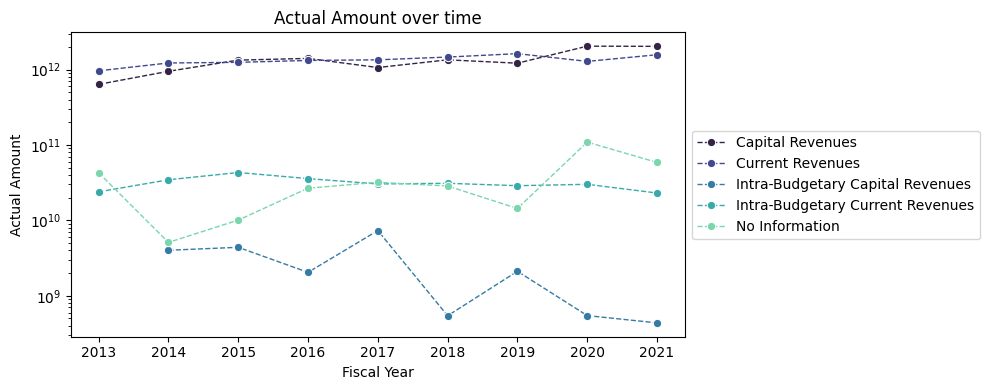

In [13]:
# logarithmic scale
time_evolution(df_years, 'Actual Amount', scale='log')

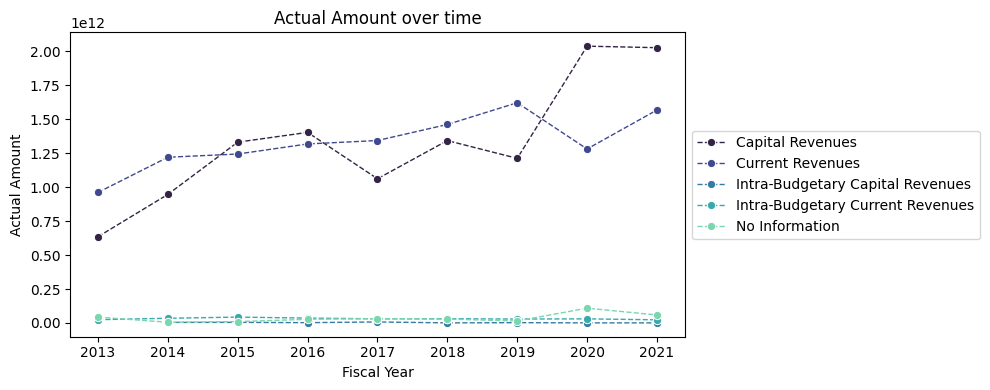

In [14]:
# linear scale
time_evolution(df_years, 'Actual Amount')

+ We observe a slight increase of `Capital Revenues` over time with a small drop in 2020 that could be related to Covid-19 pandemic.

+ `Current Revenues` has a bit sharper rise with a drop in 2017 that could be caused by the Brazilian crisis during 2014-2017.

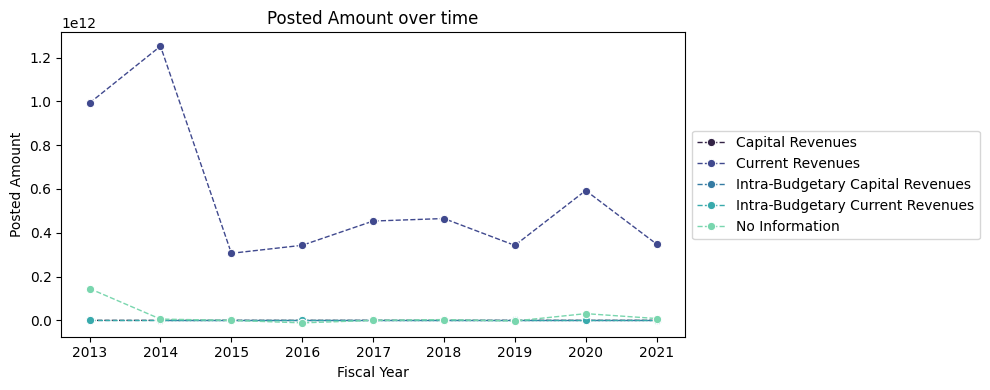

In [15]:
time_evolution(df_years, 'Posted Amount')

Since we have a lot of missing data, Posted Amount over time is difficult to analyze

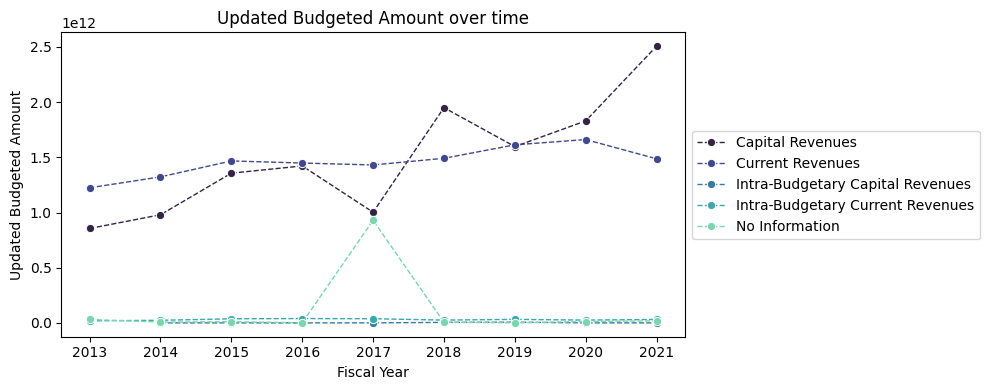

In [16]:
time_evolution(df_years, 'Updated Budgeted Amount')

We can also compare the `Budgeted Amount`vs `Actual Amount` regardless the `Economic Category`.

In [25]:
# For this purpose we have to stack the dataframe including a column for the Value Type
df_melt = df_years.melt(id_vars="Fiscal Year", value_vars=["Updated Budgeted Amount", "Actual Amount"], var_name="Value Type", value_name="Amount")
df_melt.head()

,Fiscal Year,Value Type,Amount
0,2013,Updated Budgeted Amount,8.553426e+11
1,2014,Updated Budgeted Amount,9.795545e+11
2,2015,Updated Budgeted Amount,1.356511e+12
3,2016,Updated Budgeted Amount,1.421812e+12
4,2017,Updated Budgeted Amount,1.002567e+12


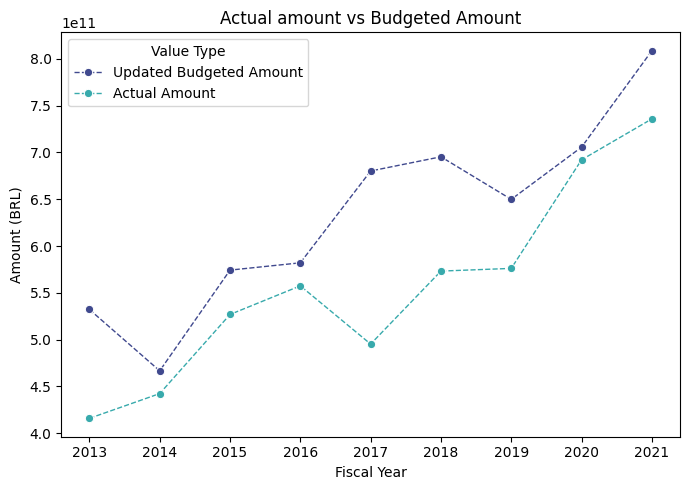

In [29]:
plt.figure(figsize = (7, 5))

sns.lineplot(x="Fiscal Year",
            y="Amount",
            hue = "Value Type",
            data= df_melt,
            marker = "o", 
            linestyle = 'dashed',
            linewidth = 1, 
            palette="mako",  
            errorbar = None, 
            )

plt.title("Actual amount vs Budgeted Amount")
plt.xlabel("Fiscal Year")
plt.ylabel("Amount (BRL)")
plt.tight_layout()
plt.show()

Budgeted revenues consistently exceed the actual revenues collected, as inferred during the exploratory data analysis. While the projected and actual amounts align more closely in 2014, 2015, and 2016, there are significant discrepancies in 2017, 2018, and 2019, indicating overestimations. This gap narrows again in 2020, suggesting a more cautious approach in budget forecasting during that year. The trends highlight the challenges in accurately projecting revenues, with certain years reflecting better alignment between expectations and outcomes compared to others.

### Boxplot

---

We can use a boxplot to visualize the distribution of values per category

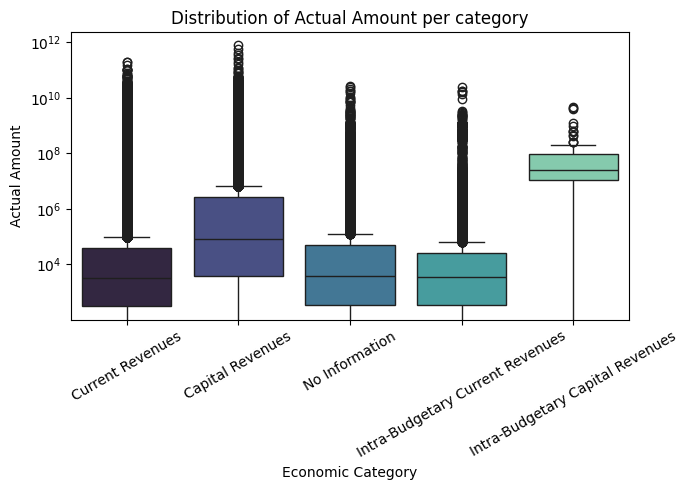

In [16]:
box_plot(df, 'Actual Amount', scale='log')

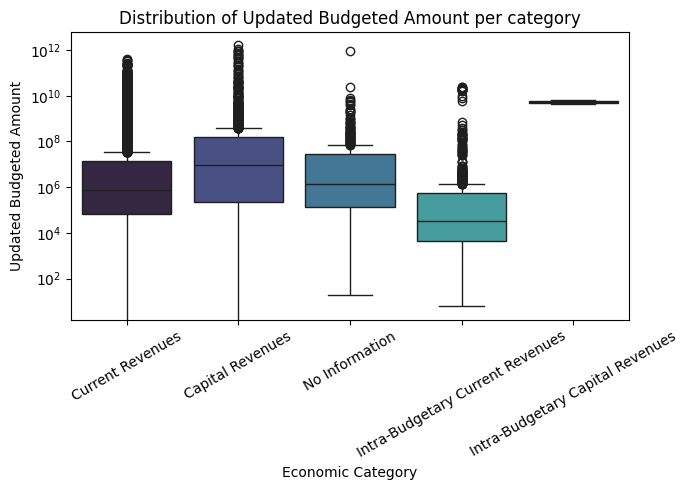

In [17]:
box_plot(df, 'Updated Budgeted Amount', scale='log')

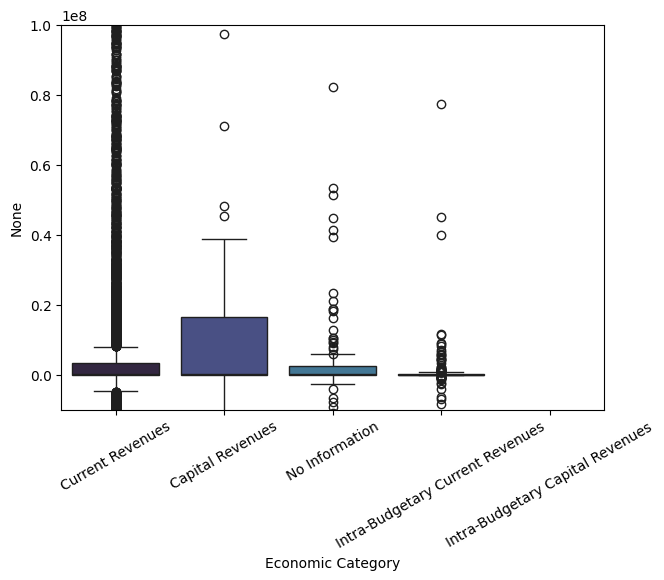

In [36]:
plt.figure(figsize = (7, 5))

sns.boxplot(x = 'Economic Category',
            y = df['Updated Budgeted Amount']-df['Actual Amount'],
            data = df,
            palette = 'mako'
            )

plt.xticks(rotation = 30)
plt.ylim(-1e7, 1e8)
plt.show()

---

We can also plot the evolution of `Actual Amount`per `Superior Agency` (and `Agency` and `Managing Unit`). Since there are a lot of categories we will show only the 5 with the most amount of revenue.

In [76]:
# List of top 5 Superior Agencies
superior_agencies = df.groupby('Superior Agency')['Actual Amount'].sum().nlargest(5).index
# Filter
sa_filter = df['Superior Agency'].isin(superior_agencies)
df_sa_filtered = df[sa_filter]
# Data frame with the top 5 grouped by Fiscal Year and sum the Amount
df_sa_grouped = df_sa_filtered.groupby(['Superior Agency', 'Fiscal Year'])['Actual Amount'].sum().reset_index(name='amount')

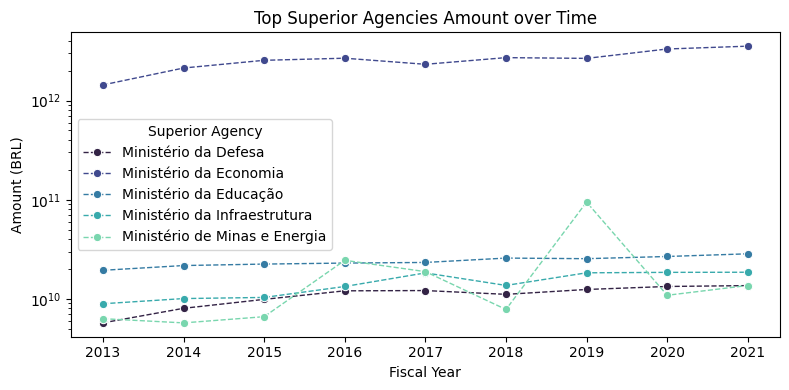

In [77]:
plt.figure(figsize=(8, 4))

sns.lineplot(x='Fiscal Year',
             y='amount',
             hue='Superior Agency',
             marker='o',
             linestyle='dashed',
             linewidth=1,
             errorbar=None,
             palette='mako',
             data=df_sa_grouped)

plt.xlabel('Fiscal Year')
plt.ylabel('Amount (BRL)')
plt.title('Top Superior Agencies Amount over Time')
plt.yscale('log')
plt.tight_layout()
plt.show()

Key insights:

+ Ministério da Economia consistently received the highest amounts.

+ Ministério da Educação, Ministério da Infraestrutura and Ministério da Defesa have smaller, relatively stable allocations over time compared to the other agencies.

+ Ministério de Minas e Energia has a noticeable peak in 2019. Outside of this peak, its allocation trends are similar to the more stable ministries, implying a significant event or policy decision that resulted in a sharp increase in that particular year.